In [15]:
import pandas as pd
data = pd.read_excel('AirQualityUCI.xlsx')

In [16]:
data.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

## 互相关系数

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
def test1(df):
    dfData = df.corr(method = 'pearson')
    plt.subplots(figsize=(18, 18)) # 设置画面大小
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    plt.show()

def test2(df):
    dfData = df.corr(method = 'kendall')
    plt.subplots(figsize=(18, 18)) # 设置画面大小
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    plt.show()

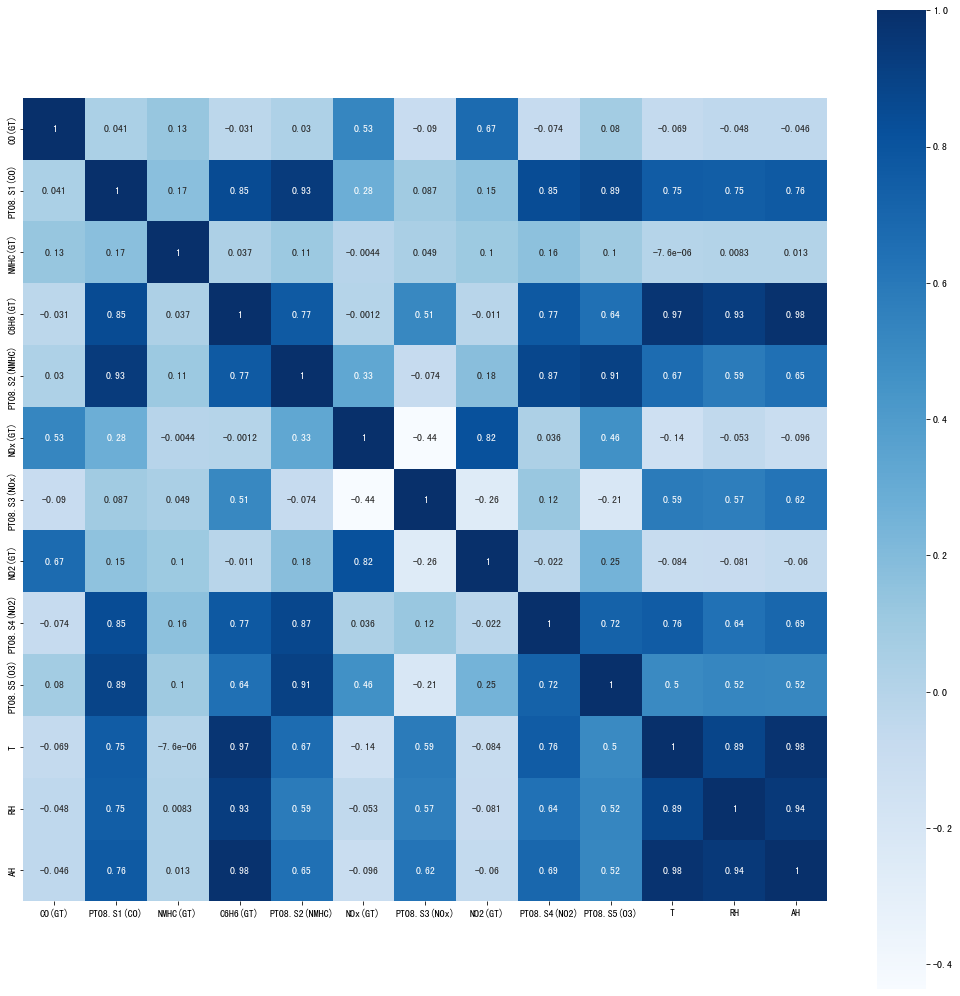

In [18]:
test1(data)

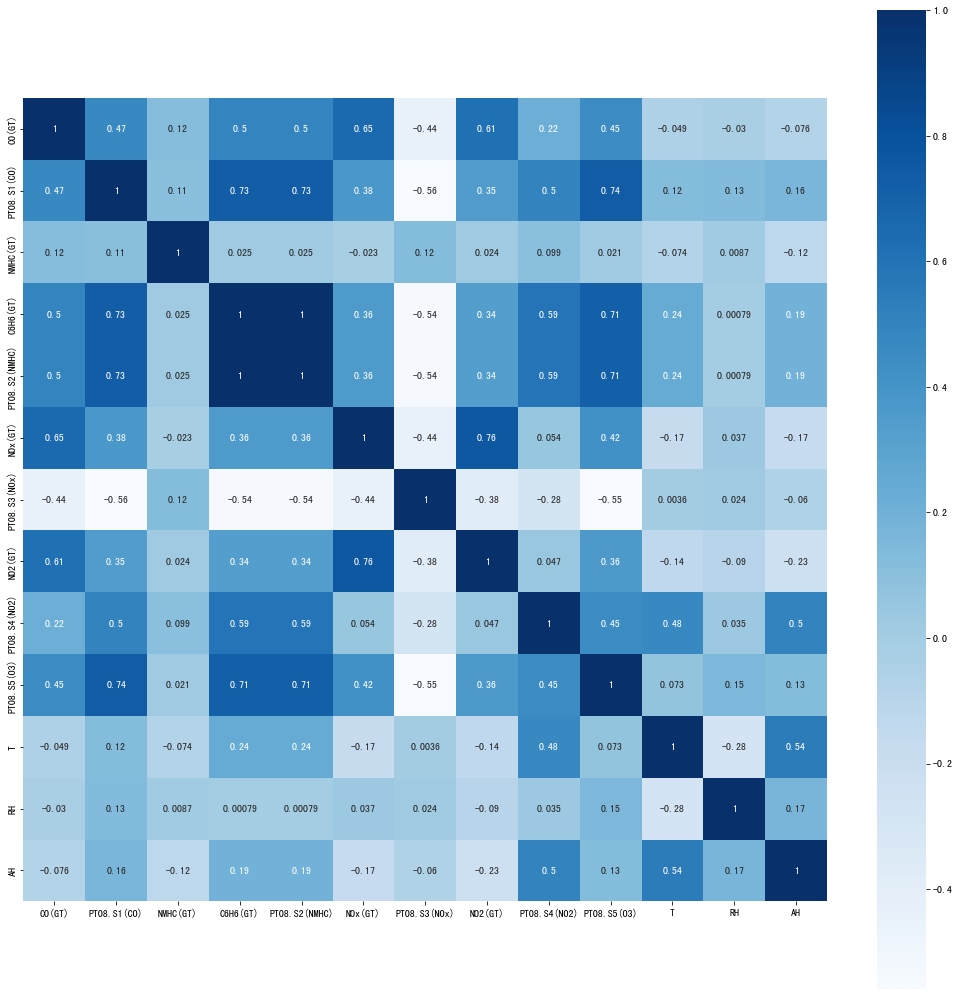

In [19]:
test2(data)

**先确定两组相关性很高的数据作为我们最终的数据 明显右下角一圈很大**

**然后做一个简单的数据预处理，即缺失值处理**

In [20]:
import numpy as np
data = data[['T','AH','RH']]
data.replace(-200,np.nan,inplace = True)
data.dropna(inplace = True)
data.drop(data[data['T'] > 40].index, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8932 entries, 0 to 9356
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       8932 non-null   float64
 1   AH      8932 non-null   float64
 2   RH      8932 non-null   float64
dtypes: float64(3)
memory usage: 279.1 KB


In [21]:
data.describe()

,T,AH,RH
count,8932.000000,8932.000000,8932.000000
mean,18.164436,1.024717,49.459614
std,8.661633,0.404800,17.144355
min,-1.900000,0.184679,9.175000
25%,11.750000,0.734761,36.175000
50%,17.650000,0.993286,49.675000
75%,24.275000,1.315003,62.600000
max,39.950001,2.231036,88.725000


## 自相关系数

In [22]:
def get_auto_corr(timeSeries,k):
    '''
    Descr:输入：时间序列timeSeries，滞后阶数k
            输出：时间序列timeSeries的k阶自相关系数
        l：序列timeSeries的长度
        timeSeries1，timeSeries2:拆分序列1，拆分序列2
        timeSeries_mean:序列timeSeries的均值
        timeSeries_var:序列timeSeries的每一项减去均值的平方的和
        
    '''
    l = len(timeSeries)
    #取出要计算的两个数组
    timeSeries1 = timeSeries[0:l-k]
    timeSeries2 = timeSeries[k:]
    timeSeries_mean = timeSeries.mean()
    timeSeries_var = np.array([i**2 for i in timeSeries-timeSeries_mean]).sum()
    auto_corr = 0
    for i in range(l-k):
        temp = (timeSeries1[i]-timeSeries_mean)*(timeSeries2[i]-timeSeries_mean)/timeSeries_var
        auto_corr = auto_corr + temp  
    return auto_corr

In [23]:
for i in range(5):
    print('滞后',i+1,'阶的自相关系数为：',get_auto_corr(np.array(data['T']),i+1))

滞后 1 阶的自相关系数为： 0.9861933398233457
滞后 2 阶的自相关系数为： 0.9581234349798001
滞后 3 阶的自相关系数为： 0.9208341108974084
滞后 4 阶的自相关系数为： 0.8783561402362051
滞后 5 阶的自相关系数为： 0.8338929715210288


## 指数平滑算法

In [24]:

#指数平滑算法
def exponential_smoothing(alpha, s):
    '''
    一次指数平滑
    :param alpha:  平滑系数
    :param s:      数据序列， list
    :return:       返回一次指数平滑模型参数， list
    '''
    s_temp = [0 for i in range(len(s))]
    s_temp[0] = ( s[0] + s[1] + s[2] ) / 3
    
    for i in range(1, len(s)):
        s_temp[i] = alpha * s[i] + (1 - alpha) * s_temp[i-1]
    return s_temp

def compute_single(alpha, s):
    '''
    一次指数平滑
    :param alpha:  平滑系数
    :param s:      数据序列， list
    :return:       返回一次指数平滑模型参数， list
    '''
    return exponential_smoothing(alpha, s)

def compute_double(alpha, s):
    '''
    二次指数平滑
    :param alpha:  平滑系数
    :param s:      数据序列， list
    :return:       返回二次指数平滑模型参数a, b， list
    '''
    s_single = compute_single(alpha, s)
    s_double = compute_single(alpha, s_single)

    a_double = [0 for i in range(len(s))]
    b_double = [0 for i in range(len(s))]

    for i in range(len(s)):
        a_double[i] = 2 * s_single[i] - s_double[i]                    #计算二次指数平滑的a
        b_double[i] = (alpha / (1 - alpha)) * (s_single[i] - s_double[i])  #计算二次指数平滑的b

    return a_double, b_double

def compute_triple(alpha, s):
    '''
    三次指数平滑
    :param alpha:  平滑系数
    :param s:      数据序列， list
    :return:       返回三次指数平滑模型参数a, b, c， list
    '''
    s_single = compute_single(alpha, s)
    s_double = compute_single(alpha, s_single)
    s_triple = exponential_smoothing(alpha, s_double)

    a_triple = [0 for i in range(len(s))]
    b_triple = [0 for i in range(len(s))]
    c_triple = [0 for i in range(len(s))]

    for i in range(len(s)):
        a_triple[i] = 3 * s_single[i] - 3 * s_double[i] + s_triple[i]
        b_triple[i] = (alpha / (2 * ((1 - alpha) ** 2))) * ((6 - 5 * alpha) * s_single[i] - 2 * ((5 - 4 * alpha) * s_double[i]) + (4 - 3 * alpha) * s_triple[i])
        c_triple[i] = ((alpha ** 2) / (2 * ((1 - alpha) ** 2))) * (s_single[i] - 2 * s_double[i] + s_triple[i])

    return a_triple, b_triple, c_triple


alpha = 0.5
data_x = np.array(data['T'])
sigle = compute_single(alpha, data_x)
print(alpha * data_x[-1] + (1 - alpha) * sigle[-1])


27.932350107700827


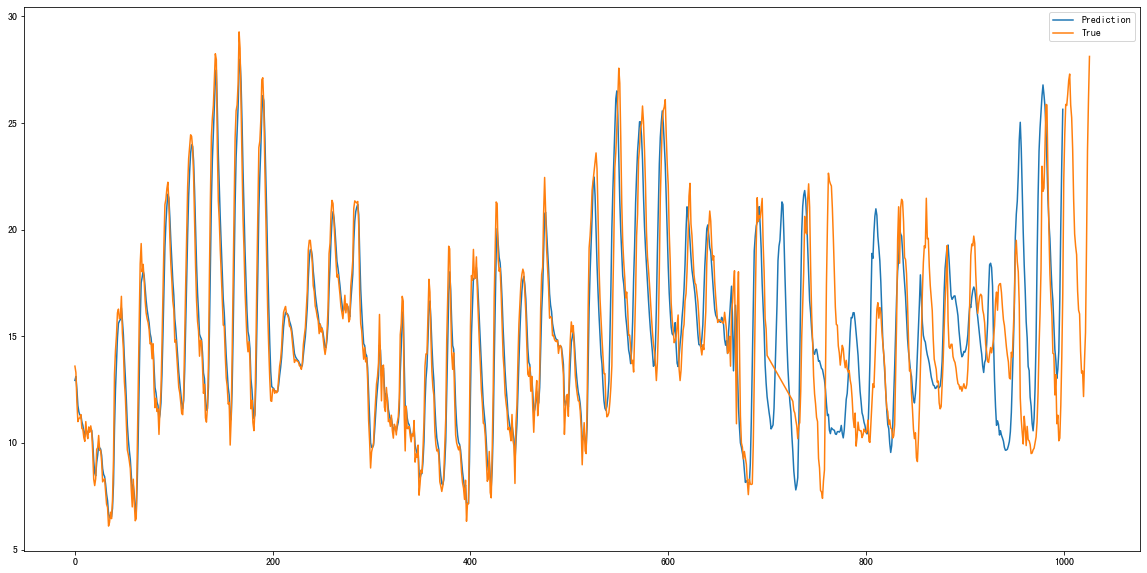

In [25]:
plt.figure(figsize = (20,10))
plt.plot(sigle[:1000],label = 'Prediction')
plt.plot(data['T'][:1000],label = 'True')
plt.legend()
plt.show()

## 最小二乘估计

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

/Users/chenyeming/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


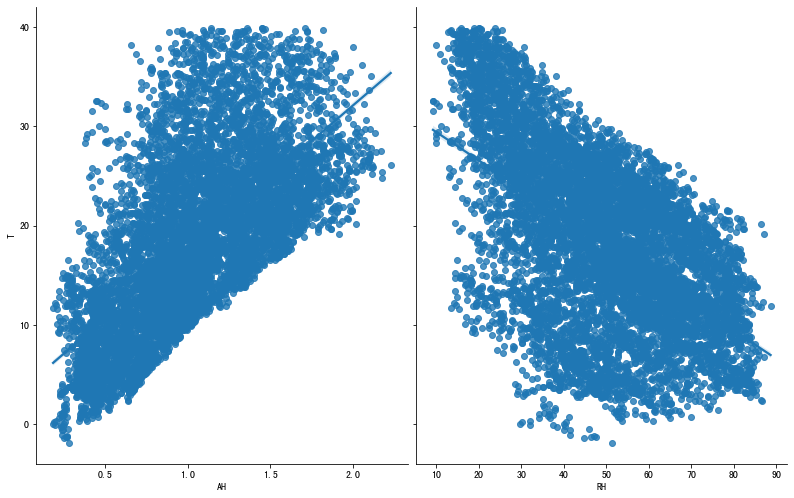

In [27]:
# 通过加入一个参数kind='reg'，seaborn可以添加一条最佳拟合直线和95%的置信带。
sns.pairplot(data, x_vars=['AH','RH'], y_vars='T', size=7, aspect=0.8,kind = 'reg')
plt.show()

In [28]:
X = data.values[:,1:]
Y = data.values[:,0]
model = LinearRegression()
 
model.fit(X,Y)
 
a  = model.intercept_#截距
 
b = model.coef_#回归系数
 
print("最佳拟合线:截距",a,",回归系数：",b)

最佳拟合线:截距 18.39957766890616 ,回归系数： [16.8840177  -0.35456161]


## 组合模型

## 仿真模拟

In [29]:
#第一步 随机注错，错误的位置和数值随便选 待研究的错误率5% 10% 15% 20% ～ 40%，其余错误率5%
#第二步 计算待研究数据滞后1-5期的自相关系数
#第三步 计算彼此之间的pearson系数，以及对应的双侧显著性
#第四步 划分训练集测试集，前90%做训练，后10%做测试
#第五步 确定超参数，平滑系数设置0.5、权重系数看喜好、最优阈值由置信区间法来定

In [30]:
import random

def make_one_column_mistake(dat,percent):
    #dat是一维数据，percent是错误率
    #返回一个大小一样的新数据
    number = int(len(dat) * percent)
    list_temp = np.arange(len(dat))
    random.shuffle(list_temp)
    list_temp = list_temp[:number]
    random_temp_list = np.zeros(len(list_temp))
    for i in range(len(list_temp)):
        while 1:
            temp_number = random.uniform(dat[list_temp[i]] - 10,dat[list_temp[i]] + 10)
            if abs(temp_number - dat[list_temp[i]]) > 5:
                random_temp_list[i] = temp_number
                break
    for i in range(len(list_temp)):
        dat[list_temp[i]] = random_temp_list[i]
    return list_temp,dat

def get_mistake_data(dataa,kernel_per,per):
    #data是总数据
    #kernel_per是待研究数据的错误率 per是其余数据错误率
    #待研究放在第一列
    dataa = np.array(dataa)
    list_temp,temp1 = make_one_column_mistake(dataa[:,0],kernel_per)
    temp1 = temp1.reshape(-1,1)
    _,temp2 = make_one_column_mistake(dataa[:,1],per)
    temp2 = temp2.reshape(-1,1)
    _,temp3 = make_one_column_mistake(dataa[:,2],per)
    temp3 = temp3.reshape(-1,1)
    dataa = np.hstack((temp1,temp2,temp3))
    return dataa,list_temp

In [31]:
#数据注错
data_new,wrong_index = get_mistake_data(data,0.1,0.05)

#训练数据，测试数据划分
train_data = data_new[:int(len(data_new)*0.95)]
test_data = data_new[int(len(data_new)*0.95):]

#训练集拟合最小二乘
X = train_data[:,1:]
Y = train_data[:,0]
model = LinearRegression()
model.fit(X,Y)
a,b  = model.intercept_, model.coef_
print("最佳拟合线:截距",a,",回归系数：",b)

#平滑算法
alpha = 0.5

sigle = compute_single(alpha, data_new[:,0])
first = np.array(sigle[int(len(data_new)*0.95):])

#在测试集上测试结果
second = model.predict(test_data[:,1:])

y_true = data_new[int(len(data_new)*0.95):,0]

#设置加权系数
beta = 0.8
answer = beta * first + (1 - beta) * second

#设置预测阈值
threshold = 4
index_predict_bad = np.where(abs(y_true - answer) > threshold)[0]
index_true_bad = np.sort(wrong_index[wrong_index > int(len(data_new)*0.95)] - int(len(data_new)*0.95))

checkout = np.array(list(set(index_predict_bad).intersection(set(index_true_bad))))
cover = np.array(list(set(index_true_bad).intersection(set(index_predict_bad))))
missing = np.array(list(set(index_true_bad).difference(set(index_predict_bad))))
misunderstanding = np.array(list(set(index_predict_bad).difference(set(index_true_bad))))

print('修复成功率',len(cover) / len(index_true_bad))
print('误检率',len(misunderstanding) / len(index_predict_bad))
print('正确率',len(checkout) / len(index_predict_bad))

最佳拟合线:截距 31.577234588033665 ,回归系数： [ 0.9156229  -0.29020915]
修复成功率 0.6595744680851063
误检率 0.03125
正确率 0.96875


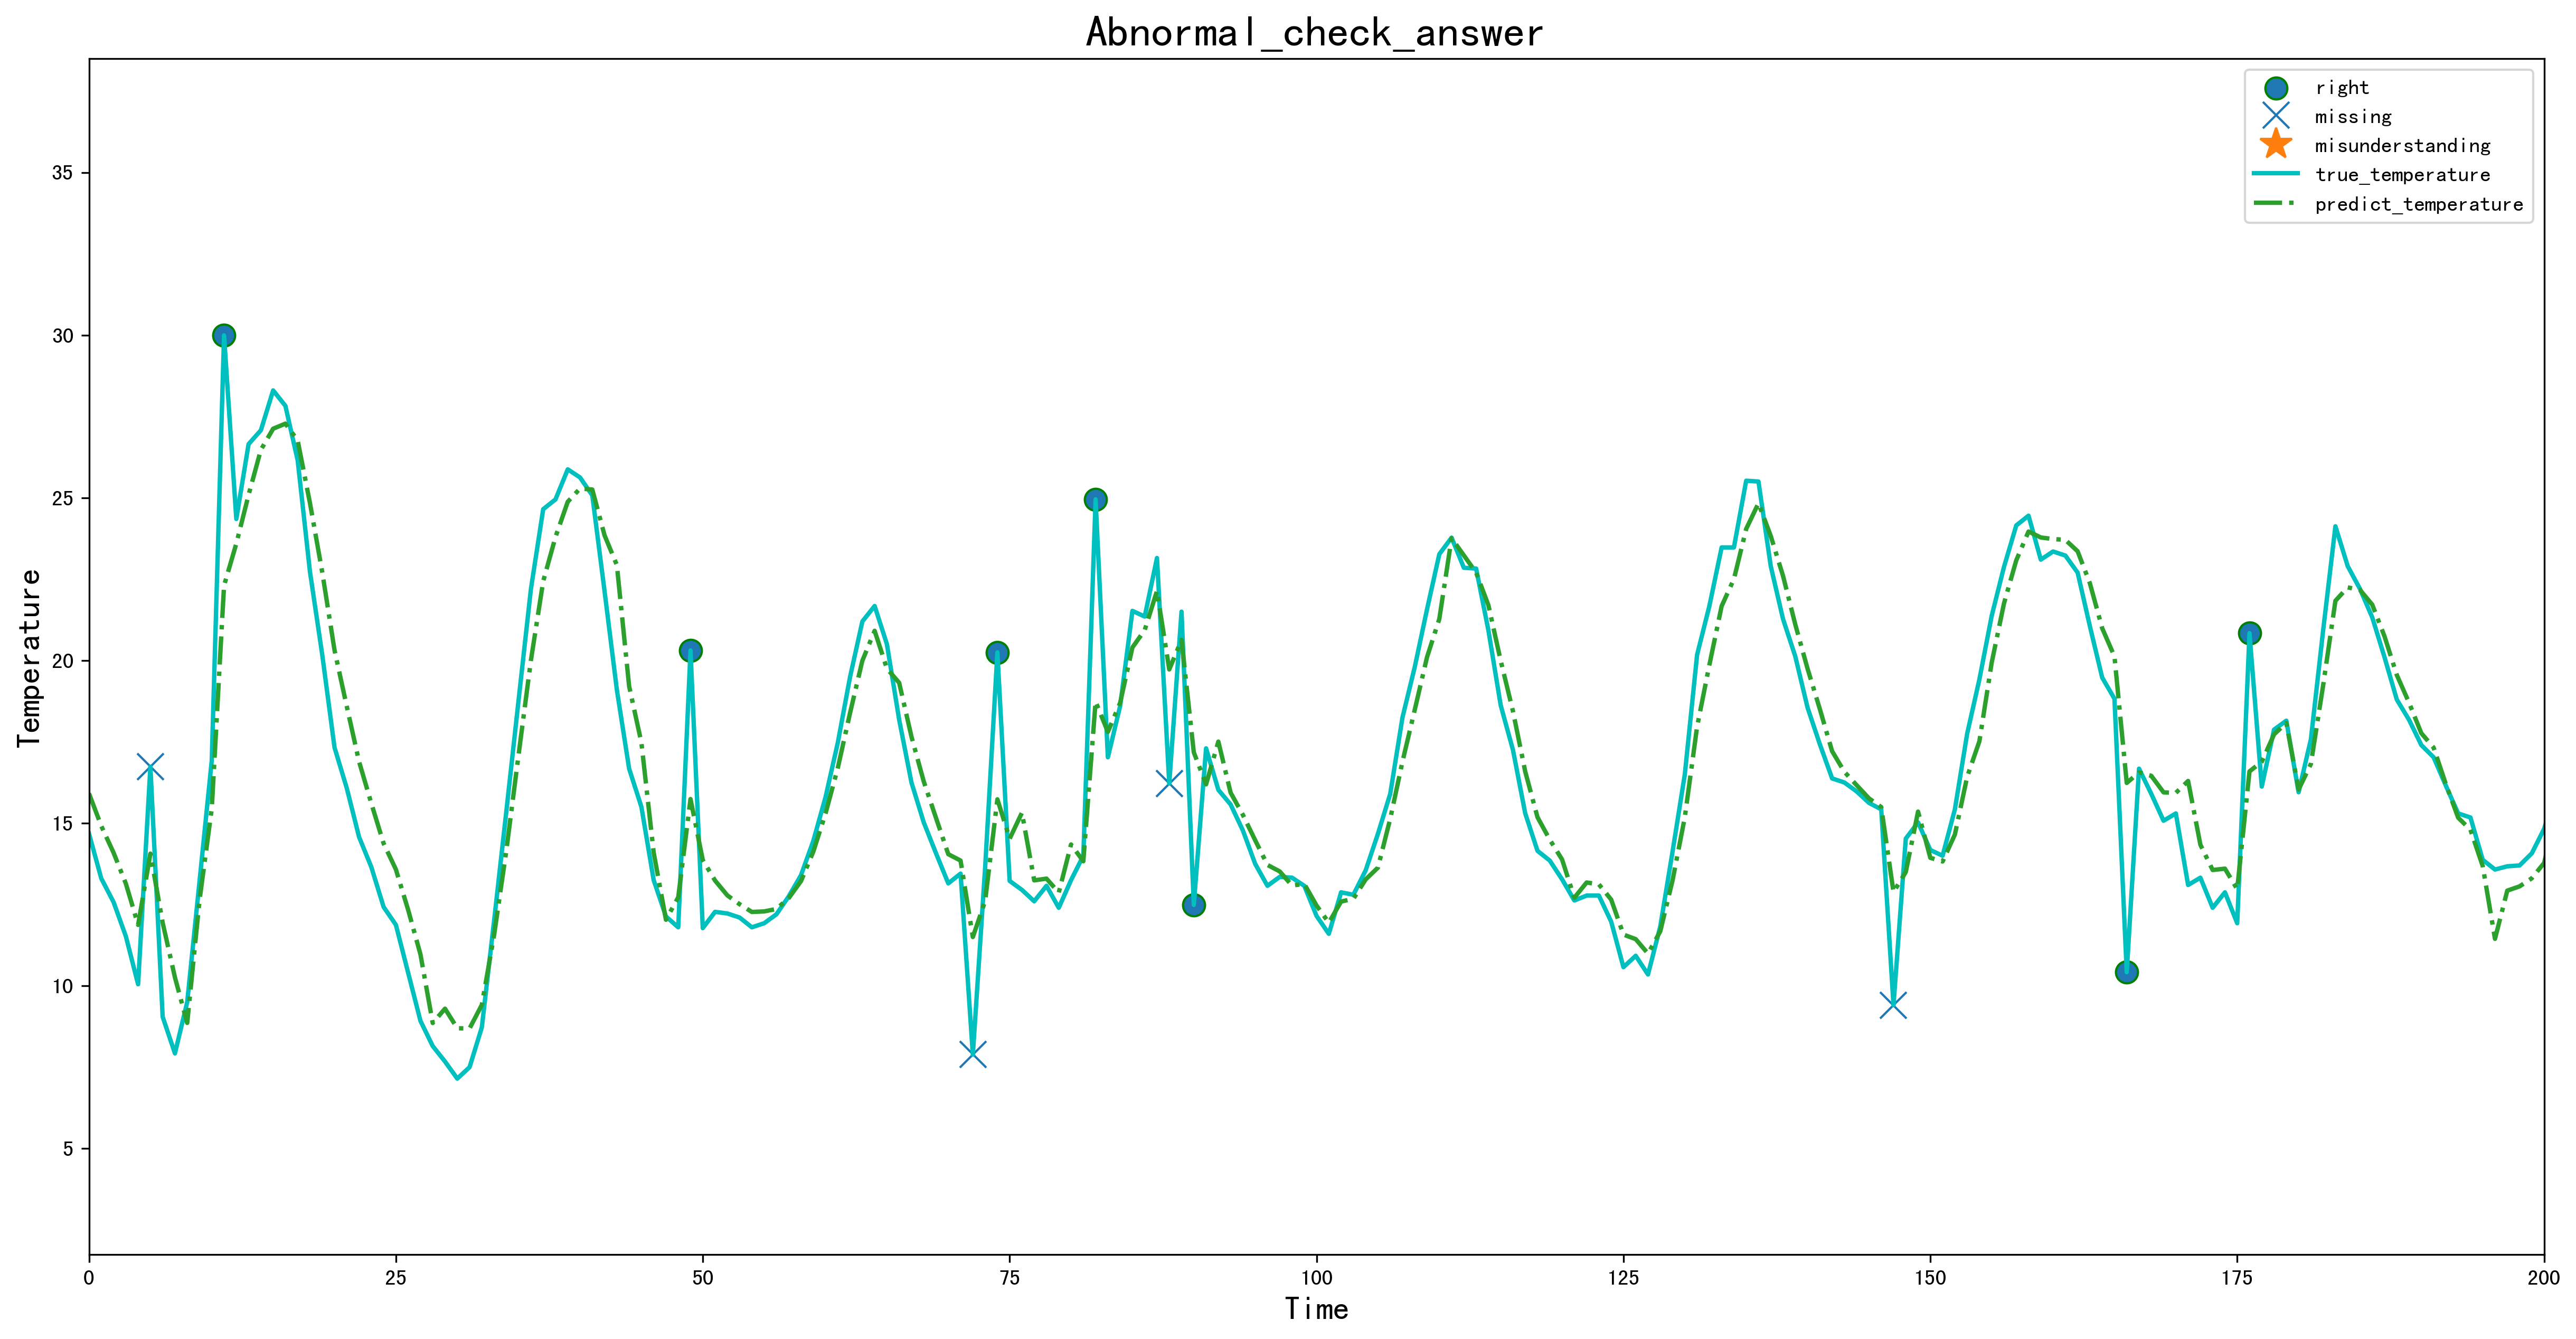

In [32]:
import warnings 
warnings.filterwarnings("ignore")

plt.figure(figsize = (20,10),dpi = 300)
plt.title('Abnormal_check_answer',fontsize = 20)
plt.xlabel('Time',fontsize = 15)
plt.ylabel('Temperature',fontsize = 15)
plt.scatter(checkout,y_true[checkout], label = 'right', marker='o', edgecolors='g', s=100)
plt.plot(missing,y_true[missing],'x',label = 'missing',markerfacecolor="black",markersize = 12)
plt.plot(misunderstanding,answer[misunderstanding],'*',label = 'misunderstanding',markersize = 15)
plt.plot(y_true,'c',linewidth = 2,label = 'true_temperature')
plt.plot(answer,'-.',linewidth = 2,label = 'predict_temperature')
plt.xlim(0,200)
plt.legend()
plt.savefig('out.jpg')
plt.show()

In [33]:
def compare_rate(data,my_rate,method):
    #数据注错
    data_new,wrong_index = get_mistake_data(data,my_rate,0.05)

    #训练数据，测试数据划分
    train_data = data_new[:int(len(data_new)*0.95)]
    test_data = data_new[int(len(data_new)*0.95):]

    #训练集拟合最小二乘
    X = train_data[:,1:]
    Y = train_data[:,0]
    model = LinearRegression()
    model.fit(X,Y)
    a,b  = model.intercept_, model.coef_
    #print("最佳拟合线:截距",a,",回归系数：",b)

    #平滑算法
    alpha = 0.5

    sigle = compute_single(alpha, data_new[:,0])
    first = np.array(sigle[int(len(data_new)*0.95):])

    #在测试集上测试结果
    second = model.predict(test_data[:,1:])

    y_true = data_new[int(len(data_new)*0.95):,0]
    if method ==0:
    #设置加权系数
        beta = 0.8
    elif method == 1:
        beta = 1
    else:
        beta = 0
    answer = beta * first + (1 - beta) * second

    #设置预测阈值
    threshold = 3
    index_predict_bad = np.where(abs(y_true - answer) > threshold)[0]
    index_true_bad = np.sort(wrong_index[wrong_index > int(len(data_new)*0.95)] - int(len(data_new)*0.95))

    checkout = np.array(list(set(index_predict_bad).intersection(set(index_true_bad))))
    missing = np.array(list(set(index_true_bad).difference(set(index_predict_bad))))
    misunderstanding = np.array(list(set(index_predict_bad).difference(set(index_true_bad))))

    #print('误检率',len(misunderstanding) / len(index_predict_bad))
    #print('正确率',len(checkout) / len(index_predict_bad))
    return len(misunderstanding) / len(index_predict_bad),len(checkout) / len(index_predict_bad),len(cover) / len(index_true_bad)

In [34]:
mix1 = []
mix2 = []
mix3 = []
for i in np.arange(0.1,0.5,0.05):
    a,b,c = compare_rate(data,i,0)
    mix1.append(a)
    mix2.append(b)
    mix3.append(c)
first1 = []
first2 = []
first3 = []
for i in np.arange(0.1,0.5,0.05):
    a,b,c = compare_rate(data,i,1)
    first1.append(a)
    first2.append(b)
    first3.append(c)

second1 = []
second2 = []
second3 = []
for i in np.arange(0.1,0.5,0.05):
    a,b,c =compare_rate(data,i,2)
    second1.append(a)
    second2.append(b)
    second3.append(c)

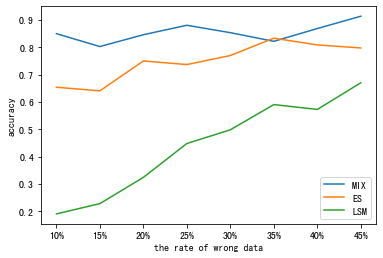

In [35]:
x_text = ['10%','15%','20%','25%','30%','35%','40%','45%']
plt.plot(x_text,mix2,label = 'MIX')
plt.plot(x_text,first2,label = 'ES')
plt.plot(x_text,second2,label = 'LSM')
plt.xlabel('the rate of wrong data')
plt.ylabel('accuracy')
plt.legend()
plt.show()

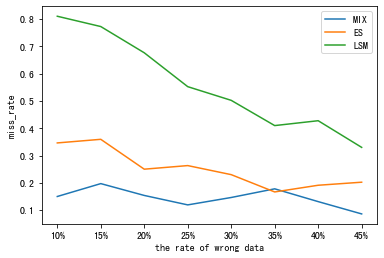

In [36]:
x_text = ['10%','15%','20%','25%','30%','35%','40%','45%']
plt.plot(x_text,mix1,label = 'MIX')
plt.plot(x_text,first1,label = 'ES')
plt.plot(x_text,second1,label = 'LSM')
plt.xlabel('the rate of wrong data')
plt.ylabel('miss_rate')
plt.legend()
plt.show()

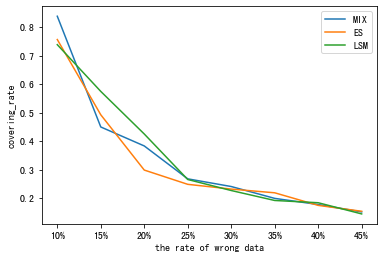

In [37]:
x_text = ['10%','15%','20%','25%','30%','35%','40%','45%']
plt.plot(x_text,mix3,label = 'MIX')
plt.plot(x_text,first3,label = 'ES')
plt.plot(x_text,second3,label = 'LSM')
plt.xlabel('the rate of wrong data')
plt.ylabel('covering_rate')
plt.legend()
plt.show()